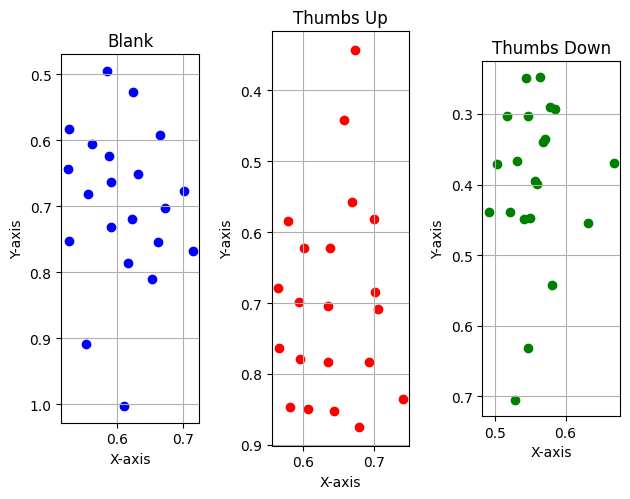

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import random

def plotData(df, row_index, ax, color, title):
    if df is not None:
        row = df.iloc[row_index]
        x_coords = [row[f"landmark_{i}_x"] for i in range(0, num_landmarks)]
        y_coords = [row[f"landmark_{i}_y"] for i in range(0, num_landmarks)]
        ax.scatter(x_coords, y_coords, color=color)
        ax.set_title(title)
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.invert_yaxis()
        ax.grid(True)
        ax.set_aspect('equal')

#row_index = 0  # Random row
numPlots = 0
num_landmarks = 21 # Number of landmarks/features

try:
    df_blank = pd.read_csv("Data/blank_data.csv")
    numPlots += 1
except:
    print("Data/blank_data.csv not found. Please run the script to generate the data first.")
    df_blank = None

try:
    df_up = pd.read_csv("Data/thumbs_up_data.csv")
    numPlots += 1

except:
    print("Data/thumbs_up_data.csv not found. Please run the script to generate the data first.")
    df_up = None

try:
    df_down = pd.read_csv("Data/thumbs_down_data.csv")
    numPlots += 1
except:
    print("Data/thumbs_down_data.csv not found. Please run the script to generate the data first.")
    df_down = None


fig, axes = plt.subplots(1, numPlots)

if numPlots == 1:
    axes = [axes]

# Pick random entry to plot
plotData(df_blank, random.randint(0, len(df_blank) - 1), axes[0], 'blue', df_blank['gesture_label'][0])
plotData(df_up, random.randint(0, len(df_down) - 1), axes[1], 'red', df_up['gesture_label'][0])
plotData(df_down, random.randint(0, len(df_down) - 1), axes[2], 'green', df_down['gesture_label'][0])

# Check to see data points make sense, i.e., plots looks like a hand
plt.subplots_adjust(wspace=5)
plt.tight_layout()
plt.show()

In [3]:
num_output_classes = 3

batch_size = 128
step_to_print = 100
num_epochs = 500
num_neurons_layer_1 = 128
num_neurons_layer_2 = 64

In [4]:
# Initialize weights and biases

import tensorflow as tf

random_normal = tf.initializers.RandomNormal()

weights = {
    'w_l1': tf.Variable(random_normal([num_landmarks, num_neurons_layer_1])),
    'w_l2': tf.Variable(random_normal([num_neurons_layer_1, num_neurons_layer_2])),
    'w_out': tf.Variable(random_normal([num_neurons_layer_2, num_output_classes]))
}
biases = {
    'b_l1': tf.Variable(tf.zeros([num_neurons_layer_1])),
    'b_l2': tf.Variable(tf.zeros([num_neurons_layer_2])),
    'b_out': tf.Variable(tf.zeros([num_output_classes]))
}

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Combine the datasets for training
df = pd.concat([df_blank, df_up, df_down])

df_size = len(df)

X = df.drop(columns=["gesture_label"]) # get the landmark coordinates
y = df["gesture_label"].values # get the gesture labels

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Encodes labels as integers (0, 1, 2)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1) # batch & shuffle the data

In [6]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class FCNN(Model):
    def __init__(self, num_neurons_layer_1, num_neurons_layer_2, num_output_classes, **kwargs):
        super(FCNN, self).__init__(**kwargs)
        self.num_neurons_layer_1 = num_neurons_layer_1
        self.num_neurons_layer_2 = num_neurons_layer_2
        self.num_output_classes = num_output_classes
        self.l1 = Dense(num_neurons_layer_1, activation='relu')
        self.l2 = Dense(num_neurons_layer_2, activation='relu')
        self.out = Dense(num_output_classes)

    def call(self, x, training=False):
        x = self.l1(x)
        x = self.l2(x)
        x = self.out(x)
        if not training:
            x = tf.nn.softmax(x)
        return x

    def get_config(self):
        config = super(FCNN, self).get_config()
        config.update({
            "num_neurons_layer_1": self.num_neurons_layer_1,
            "num_neurons_layer_2": self.num_neurons_layer_2,
            "num_output_classes": self.num_output_classes,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [7]:
# Loss function
def loss_func(x,y):
    y = tf.cast(y, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    return tf.reduce_mean(loss)

In [8]:
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [9]:
fcnn = FCNN(num_neurons_layer_1, num_neurons_layer_2, num_output_classes) #  Instance of the model

optimizer = tf.optimizers.SGD() # Optimizer - Stochastic Gradient Descent

In [10]:
def optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = fcnn(x, training=True)
        loss = loss_func(pred, y)
        
    weights_and_biases = fcnn.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, weights_and_biases)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, weights_and_biases))

In [11]:
# Train the model
training_steps = (df_size // batch_size) * num_epochs

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    optimization(batch_x, batch_y)
    
    if step % step_to_print == 0:
        pred = fcnn(batch_x, training=True)
        loss = loss_func(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 100, loss: 0.835882, accuracy: 0.585938
step: 200, loss: 0.699168, accuracy: 0.648438
step: 300, loss: 0.641793, accuracy: 0.695312
step: 400, loss: 0.564218, accuracy: 0.726562
step: 500, loss: 0.511251, accuracy: 0.765625
step: 600, loss: 0.418598, accuracy: 0.882812
step: 700, loss: 0.382296, accuracy: 0.890625
step: 800, loss: 0.342136, accuracy: 0.875000
step: 900, loss: 0.257917, accuracy: 0.921875
step: 1000, loss: 0.240254, accuracy: 0.929688
step: 1100, loss: 0.242334, accuracy: 0.960938
step: 1200, loss: 0.199709, accuracy: 0.953125
step: 1300, loss: 0.177416, accuracy: 0.929688
step: 1400, loss: 0.242893, accuracy: 0.898438
step: 1500, loss: 0.246808, accuracy: 0.914062
step: 1600, loss: 0.171157, accuracy: 0.960938
step: 1700, loss: 0.175627, accuracy: 0.953125
step: 1800, loss: 0.132880, accuracy: 0.968750
step: 1900, loss: 0.114217, accuracy: 0.984375
step: 2000, loss: 0.121400, accuracy: 0.992188
step: 2100, loss: 0.133045, accuracy: 0.976562
step: 2200, loss: 0.12

In [12]:
# Test the model
pred = fcnn(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.995680


In [13]:
fcnn.save("Model/hand_gesture_model.keras") # Save the model